In [11]:
require(tidyverse)
require(data.table)
require(ggplot2)

require(chromVAR)
require(SummarizedExperiment)
require(RColorBrewer)
require(extrafont)  # fonts 
# https://blog.revolutionanalytics.com/2012/09/how-to-use-your-favorite-fonts-in-r-charts.html
suppressMessages(loadfonts())
require(ggthemes)
# #https://rpubs.com/Koundy/71792 theme_Publication
require(ComplexHeatmap)
cols.hm.avg.tf <- colorRampPalette(c(rgb(249, 249, 212, maxColorValue = 255), rgb(60, 
    181, 195, maxColorValue = 255), rgb(30, 35, 86, maxColorValue = 255)), space = "Lab")

require(ggpubr)
require(gghighlight)
require(pheatmap)

theme_pubr<- function (base_size = 11, base_family = "Arial") 
{
    theme_foundation() + theme(line = element_line(colour = "black", 
        lineend = "round", linetype = "solid"), rect = element_rect(fill = "white", 
        colour = "black", linetype = "solid"), text = element_text(colour = "black", 
        face = "plain", family = base_family, size = base_size, 
        vjust = 0.5, hjust = 0.5, lineheight = 0.5), panel.background = element_blank(), 
        plot.background = element_blank(), panel.border = element_rect(colour = "black", 
            fill = NA), panel.grid = element_blank(), strip.background = element_rect(colour = NA), 
        legend.key = element_rect(colour = NA), title = element_text(size = rel(1)), 
        plot.title = element_text(size = rel(1.2), face = "bold"), 
        strip.text = element_text(), axis.ticks.length = unit(1, 
    "mm"))
}
require(ggrepel)

## Padj again after filtering peaks only present in peak calling for the tested cell types

### recalculate

In [4]:
res.transcript_level<-fread("../figures/Fig2/subfigs/fig_2.prom.sub_vs_sub.fisher.csv")
res.transcript_level%>%head(1)
res.transcript_level%>%nrow

prom_peak,gene,celltype,type1_frac,type2_frac,odds,pval,FDR,padj.Bonferroni,FDR.BY
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1:10002866-10003720,LZIC,alpha,0.05374687,0.06523856,0.8138749,0.08365895,0.1429331,1,1


[1] 53645

In [5]:
res.transcript_level<- res.transcript_level %>% mutate(substate = ifelse(odds > 1, paste0(celltype, "_1"), 
    paste0(celltype, "_2")))
res.transcript_level%>%head(1)

prom_peak,gene,celltype,type1_frac,type2_frac,odds,pval,FDR,padj.Bonferroni,FDR.BY,substate
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1:10002866-10003720,LZIC,alpha,0.05374687,0.06523856,0.8138749,0.08365895,0.1429331,1,1,alpha_2


In [8]:
# adjust for p value
m <- c("fdr", "bonferroni", "BY")
names(m) <- c("FDR", "padj.Bonferroni", "FDR.BY")
res.transcript_level.2 <- do.call(rbind, lapply(c("alpha_1", "alpha_2", "beta_1", 
    "beta_2", "delta_1", "delta_2"), function(ct) {
    # ct <- 'alpha'
    res.genes_level.a.df <- res.transcript_level %>% filter(substate == ct) %>% select(prom_peak, 
        pval, substate) %>% distinct %>% as.data.frame
    res.genes_level.a.df %>% nrow %>% print
    if (F) {
        res.genes_level.a.df <- res.genes_level.a.df %>% filter(prom_peak %in% (res.peak %>% 
            filter(grepl(ct, V4)) %>% pull(prom_peak)))
        res.genes_level.a.df %>% nrow %>% print
        
    }
    
    for (i in 1:3) {
        res.genes_level.a.df[[names(m)[i]]] <- p.adjust(as.numeric(res.genes_level.a.df$pval), 
            method = m[i])
    }
    res.genes_level.a.df
}))
head(res.transcript_level.2, 1)


[1] 5652
[1] 11370
[1] 9025
[1] 7902
[1] 3055
[1] 11497


prom_peak,pval,substate,FDR,padj.Bonferroni,FDR.BY
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1:100111215-100112205,0.05610592,alpha_1,0.1638815,1,1


In [15]:
res.transcript_level.2<- res.transcript_level.2%>%select(prom_peak,pval,substate,FDR,padj.Bonferroni,FDR.BY)%>%distinct
res.transcript_level.2%>%nrow

[1] 48501

In [17]:
res.transcript_level.2 %>% nrow
res.transcript_level.2 %>% left_join(res.transcript_level %>% select(prom_peak, gene, 
    celltype, substate, odds)) %>% nrow
res.transcript_level.2 <- res.transcript_level.2 %>% left_join(res.transcript_level %>% 
    select(prom_peak, gene, celltype, substate, odds))
res.transcript_level.2%>%head(1)

[1] 48501

Joining, by = c("prom_peak", "substate")


[1] 53645

Joining, by = c("prom_peak", "substate")


prom_peak,pval,substate,FDR,padj.Bonferroni,FDR.BY,gene,celltype,odds
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
1:100111215-100112205,0.05610592,alpha_1,0.1638815,1,1,PALMD,alpha,1.933956


### compare padj.bonforni 

#### old result

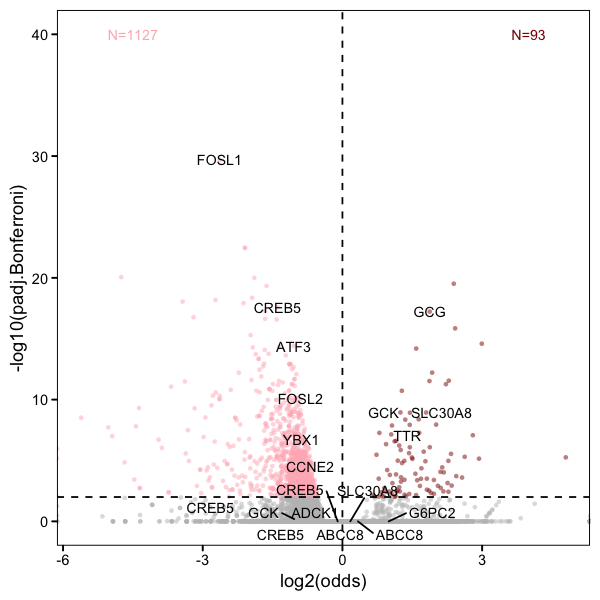

In [12]:
options(repr.plot.width = 5, repr.plot.height = 5)
pd <- res.transcript_level %>% filter(celltype == "alpha") %>% mutate(ty = ifelse(padj.Bonferroni >= 
    0.01, 0, ifelse(odds < 1, 1, 2)))
genes_anno <- c("FOSL1", "CREB5", "ATF3", "FOSL2", "YBX1", "CCNE2", "ABCC8", "ADCK1", 
    "GCG", "TTR", "GCK", "SLC30A8", "G6PC2")

pd %>% ggplot(aes(log2(odds), -log10(padj.Bonferroni))) + geom_point(aes(col = as.factor(ty)), 
    size = 1, alpha = 0.5, shape = 16) + coord_cartesian(expand = T) + theme_pubr() + 
    theme(axis.ticks.length = unit(1, "mm")) + geom_hline(yintercept = 2, color = "black", 
    linetype = 2) + geom_vline(xintercept = 0, color = "black", linetype = 2) + theme(legend.position = "none") + 
    scale_color_manual(values = c(`0` = "grey", `2` = "darkred", `1` = "lightpink")) + 
    annotate(geom = "text", x = -4.5, y = 40, label = paste0("N=", table(pd$ty)[["1"]]), 
        size = 3, color = "lightpink", family = "Arial") + annotate(geom = "text", 
    x = 4, y = 40, label = paste0("N=", table(pd$ty)[["2"]]), size = 3, color = "darkred", 
    family = "Arial") + geom_text_repel(data = pd %>% filter(gene %in% genes_anno), 
    aes(label = gene), point.padding = NA, size = 3)

#### New results

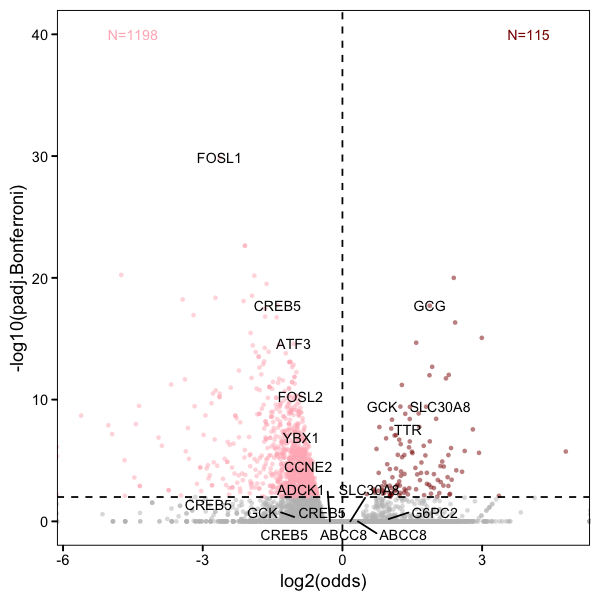

In [18]:
options(repr.plot.width = 5, repr.plot.height = 5)
pd <- res.transcript_level.2 %>% filter(celltype == "alpha") %>% mutate(ty = ifelse(padj.Bonferroni >= 
    0.01, 0, ifelse(odds < 1, 1, 2)))
genes_anno <- c("FOSL1", "CREB5", "ATF3", "FOSL2", "YBX1", "CCNE2", "ABCC8", "ADCK1", 
    "GCG", "TTR", "GCK", "SLC30A8", "G6PC2")

pd %>% ggplot(aes(log2(odds), -log10(padj.Bonferroni))) + geom_point(aes(col = as.factor(ty)), 
    size = 1, alpha = 0.5, shape = 16) + coord_cartesian(expand = T) + theme_pubr() + 
    theme(axis.ticks.length = unit(1, "mm")) + geom_hline(yintercept = 2, color = "black", 
    linetype = 2) + geom_vline(xintercept = 0, color = "black", linetype = 2) + theme(legend.position = "none") + 
    scale_color_manual(values = c(`0` = "grey", `2` = "darkred", `1` = "lightpink")) + 
    annotate(geom = "text", x = -4.5, y = 40, label = paste0("N=", table(pd$ty)[["1"]]), 
        size = 3, color = "lightpink", family = "Arial") + annotate(geom = "text", 
    x = 4, y = 40, label = paste0("N=", table(pd$ty)[["2"]]), size = 3, color = "darkred", 
    family = "Arial") + geom_text_repel(data = pd %>% filter(gene %in% genes_anno), 
    aes(label = gene), point.padding = NA, size = 3)

#### Conclusion:

Not depends too much on whether we separated substate population to do padjustment